# Filtering and Trimming Messages

In real-time chatbot development, its important to keep a track of all the conversation, so it adds more context to the users having interaction with the chatbot. 

But there are cases these message gets stacked up together, and if the message content is more then it going to increase the latency, tokens cost, etc. 

To avoid all such scenarios, we can try to employ two techniques: Filtering or Trimming the messages.

## Loading Environment Variables

In [3]:
from dotenv import load_dotenv
_ = load_dotenv()

## Initializing LLM

In [4]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage

# Initialize the Groq chat model
llm = ChatGroq(model="qwen/qwen3-32b")
llm.invoke("Hello World!")

AIMessage(content='<think>\nOkay, the user said "Hello World!" which is a classic greeting. I should respond in a friendly and welcoming way. Maybe add an emoji to keep it approachable. Let me check if there\'s any hidden context, but it seems straightforward. Just a standard greeting response should work here.\n</think>\n\nHello! 🌟 How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 11, 'total_tokens': 87, 'completion_time': 0.296746168, 'prompt_time': 0.000349525, 'queue_time': 0.048098576, 'total_time': 0.297095693}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_f17c2eb555', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--355f9f46-a25e-463d-9a0c-6954cba2ce92-0', usage_metadata={'input_tokens': 11, 'output_tokens': 76, 'total_tokens': 87})

## Building Simple Chatbot Graph

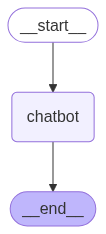

In [5]:
def chatbot(state: MessagesState): 
    return {"messages" : [llm.invoke(state["messages"])]}

# building and compiling graph
builder = StateGraph(MessagesState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

graph

In [8]:
response = graph.invoke({"messages" : [HumanMessage("Hello, how are you?")]})

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, how are you?
================================== Ai Message ==================================

<think>
Okay, the user asked how I'm doing. In our previous interactions, they've shown interest in various topics like travel, food, culture, and technology. I should respond warmly and invite them to share their thoughts. Since I can't have feelings and emotions, I need to make sure my response stays friendly and helpful while being accurate. I'll keep it open-ended to encourage them to tell me what they'd like to discuss next. No need to overcomplicate things - just a simple, approachable reply that shows I'm here to help them explore any topics that interest them.
</think>

Hi there! I'm doing well, thanks for asking! I'm always excited to chat and learn new things. How about you? I'd love to hear what's on your mind or if there's something you'd like to explore together! (•̀ᴗ•́)و


## Filtering Messages

As we notice above, if we include memory in our graph then as the conversation gets increased the number of messages gets increased along with the the number of tokens which is not recommended and also increases the token size and increaes the latency. 

## Case - 1: Modifying messages data in Original State

In short, we are going to filter or only limit our messages to past/latest 2 messages instead of considering the whole conversation.

To achieve this, we are ging to use the "Custom Reducer" function where we will remove the earlier messages until the last 2 messages in the user conversation.

### Creating a Temporary conversation b/w User and AI 

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

### Creating graph with a New Node added 

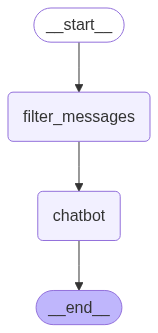

In [10]:
def filter_messages(state: MessagesState):
    updated_messages = [RemoveMessage(m.id) for m in state["messages"][:-2]]
    return { "messages" : updated_messages}
 
def chatbot(state: MessagesState): 
    return {"messages" : [llm.invoke(state["messages"])]}

# building and compiling graph
builder = StateGraph(MessagesState)

builder.add_node("chatbot", chatbot)
builder.add_node("filter_messages", filter_messages)

builder.add_edge(START, "filter_messages")
builder.add_edge("filter_messages", "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

graph

In [12]:
response = graph.invoke({"messages" : messages})

for m in response["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, the user confirmed they're researching ocean mammals and mentioned they know about whales. Now they're asking what others they should learn about. Let me start by recalling the main categories of ocean mammals besides whales.

First, there are other cetaceans like dolphins and porpoises. Then there are pinnipeds like seals, sea lions, and walruses. Sirenia includes manatees and dugongs. Marine otters, polar bears, and sea otters come to mind as well. Maybe even some less common ones like the polar bear, though they're more coastal. Oh, and the sea otter is a must-include because they're important fo

Appending the output of the above `AI Message` to the `messages` list to extend the conversation.

In [24]:
messages.append(response["messages"][-1]) 

# Adding a follow-up message to the above conversation
messages.append(HumanMessage("What about dolphins?", name="Lance", id="5"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, the user confirmed they're researching ocean mammals and mentioned they know about whales. Now they're asking what others they should learn about. Let me start by recalling the main categories of ocean mammals besides whales.

First, there are other cetaceans like dolphins and porpoises. Then there are pinnipeds like seals, sea lions, and walruses. Sirenia includes manatees and dugongs. Marine otters, polar b

## Case 2: Without modifiying Messages data in State 

In this case, instead of modifying the original state we will simply pass the messages list which only we require, to the LLM. 

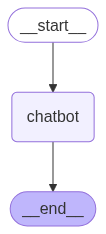

In [25]:
def chatbot(state: MessagesState): 
    return {"messages" : [llm.invoke(state["messages"][-1:])]}

# building and compiling graph
builder = StateGraph(MessagesState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

graph

In [26]:
response = graph.invoke({"messages" : messages})

for m in response["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, the user confirmed they're researching ocean mammals and mentioned they know about whales. Now they're asking what others they should learn about. Let me start by recalling the main categories of ocean mammals besides whales.

First, there are other cetaceans like dolphins and porpoises. Then there are pinnipeds like seals, sea lions, and walruses. Sirenia includes manatees and dugongs. Marine otters, polar b

## Trimming Messages 

Unlike filtering messages, Trimming messages as the name mentions it reduces the **number of tokens** in the messages and only those list of messages gets passed into the graph for the inference. 

We can use the in-built module from langchain and we can use the `trim_messages` inside our node. 

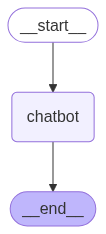

In [27]:
from langchain_core.messages import trim_messages

def chatbot(state: MessagesState): 
    # Trim the messages to 100 tokens
    messages = trim_messages(
        state["messages"], 
        max_tokens=100, 
        strategy="last",  # Keep the last messages
        allow_partial = False,  # Do not allow partial messages
        token_counter = ChatGroq(model="qwen/qwen3-32b")
    )
    
    return {"messages" : [llm.invoke(messages)]}

# building and compiling graph
builder = StateGraph(MessagesState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

graph

In [29]:
pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 23.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.30.1
    Uninstalling huggingface-hub-0.30.1:
      Successfully uninstalled huggingface-hub-0.30.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chromadb 0.5.23 requires tokenizers<=0.20.3,>=0.13.2, but you have tokenizers 0.21.4 which is incompatible.

[notice] A new release of pip is

In [30]:
graph.invoke({"messages" : messages})

/Users/saikiran/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Token indices sequence length is longer than the specified maximum sequence length for this model (1473 > 1024). Running this sequence through the model will result in indexing errors


BadRequestError: Error code: 400 - {'error': {'message': "'messages' : minimum number of items is 1", 'type': 'invalid_request_error'}}